In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from astropy import units as u
from astropy.coordinates import SkyCoord
import time
from scipy import stats
from scipy import special
import math
from IPython.display import Image
from sympy import symbols, Eq, solve

# MONTE CARLO CATALOG GENERATION

In [2]:
# This is the original blazar data
df = pd.read_csv("/mnt/c/Users/joerg/OneDrive/Dokumente/UNI/Bachelor of Science/Bachelorarbeit/Jupyter Notebook/blazar_clean.csv")
del df["Unnamed: 0"], df["SOURCE_NUMBER"], df["NAME"], df["REDSHIFT"], df["REDSHIFT_FLAG"], df["FLUX_1P4_GHZ"], df["RMAG"], df["XRAY_FLUX"], df["OBJECT_TYPE"], df["FLUX_143_GHZ"], df["GR_PHOTON_FLUX"], df["RO_SPECTRAL_INDEX"], df["l"], df["b"]
df

,RA,DEC
0,186.861167,-44.610639
1,181.245458,-50.932389
2,169.612292,-46.570828
3,195.917792,-46.350639
4,216.295708,-46.081639
...,...,...
1172,297.947750,-5.162219
1173,304.740667,-5.158169
1174,313.847417,-5.105358
1175,40.233958,-5.078328


## MC catalog generation algorithm:
This algorithm tries to replicate Buson's approach as closely as possible.
Every catalog is generated by shifting each coordinate by up to 10 degrees in a random direction.<br />
To maintain the same number of blazars inside the boundaries (1177 blazars), the coordinates of blazars which were shifted outside the boundaries get reset and shifted again until they lie within the boundaries..<br /><br />
As the calculation of theses polar coordinates takes a lot of computing power, a list of random radii and angles is created first (called solvertest). This way it is no longer necessary to calculate a new random radius/angle for every single coordinate of every catalog. Then later, for the shifting of each coordinate a random value is picked out of this list.

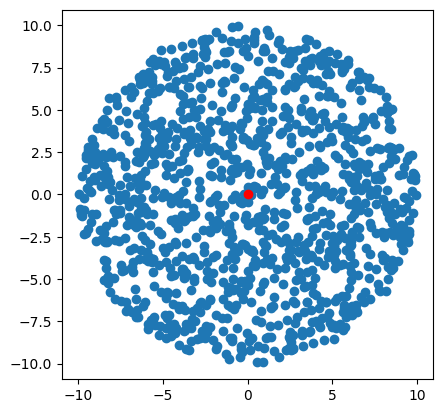

In [3]:
x=symbols('x') 
y=symbols('y') 
solvertest = []
for k in range(600):
    equation_1 = Eq((x**2 + y**2), random.uniform(0,100))
    equation_2 = Eq((y/x), math.tan(math.radians(random.uniform(0,360))))
    solvertest.append(solve((equation_1, equation_2), (x, y))[0])
    solvertest.append(solve((equation_1, equation_2), (x, y))[1])
plt.axes().set_aspect('equal', adjustable='box')
plt.scatter(np.array(solvertest)[:,0],np.array(solvertest)[:,1])
plt.scatter(0,0, c="r")
plt.show()

The catalogs are generated by the following algorithm. Currently they are stored in a dictionary called catalogs:

In [4]:
catalogs={}
for i in range(1000): # Put the number of catalogs to be generated into this range()-function
    catalogs[i] = (np.array([z+random.choice(solvertest)[0] for z in df["RA"].tolist()]), np.array([z+random.choice(solvertest)[1] for z in df["DEC"].tolist()]))  
# Shift all blazars outside the outer boundaries back inside:
    for j in range(1177):
        while np.logical_or(catalogs[i][1][j] > -5, np.logical_or(catalogs[i][1][j] < -85, np.logical_or(catalogs[i][0][j] > 360, catalogs[i][0][j] < 0))) :
            catalogs[i][1][j] = df["DEC"][j] + random.choice(solvertest)[0]
            catalogs[i][0][j] = df["RA"][j] + random.choice(solvertest)[0]
# Shift all blazars near the galactic plane into the boundaries:
    catalogs_gal = SkyCoord(ra=catalogs[i][0]*u.degree, dec=catalogs[i][1]*u.degree, frame="icrs").galactic
    for j in range(1177):
        while np.logical_or(0 < catalogs_gal.b.value[j] < 10, -10 < catalogs_gal.b.value[j] < 0):
            n = random.choice(solvertest)[0]
            if np.logical_and(df["DEC"][j] + n < -5, df["DEC"][j] + n > -85):
                catalogs[i][1][j] = df["DEC"][j] + n
                catalogs[i][0][j] = df["RA"][j] + n
                catalogs_gal.b.value[j] = SkyCoord(ra=catalogs[i][0][j]*u.degree, dec=catalogs[i][1][j]*u.degree, frame="icrs").galactic.b.value
print("DONE: Generating catalogs!")

DONE: Generating catalogs!


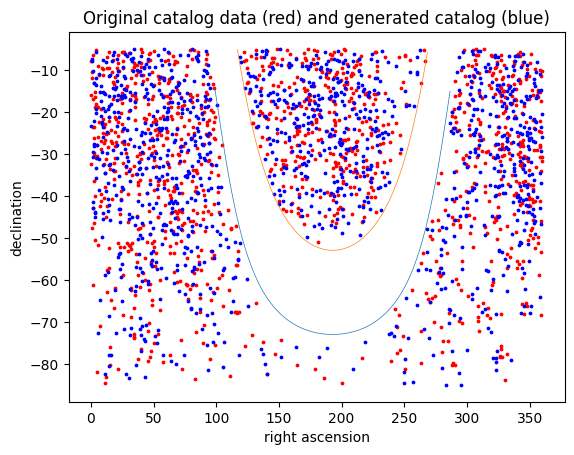

In [5]:
# Plot one of the generated catalogs:
plt.scatter(df["RA"], df["DEC"], s=3, c="r")
plt.scatter(catalogs[0][0], catalogs[0][1], s=3, c="b")
plt.title("Original catalog data (red) and generated catalog (blue)")
plt.xlabel("right ascension")
plt.ylabel("declination")

l_interval = np.linspace(0, 360, 360) - np.linspace(136, 339, 360)
galactic_plane_upper = SkyCoord(l=l_interval*u.degree, b=-10*u.degree, frame='galactic')
galactic_plane_lower = SkyCoord(l=l_interval*u.degree, b=10*u.degree, frame='galactic')
plt.plot(galactic_plane_upper.icrs.ra, galactic_plane_upper.icrs.dec, linewidth=0.5, label="galactic plane1")
plt.plot(galactic_plane_lower.icrs.ra, galactic_plane_lower.icrs.dec, linewidth=0.5, label="galactic plane2")

# Testing the Cramér-von-Mises test:

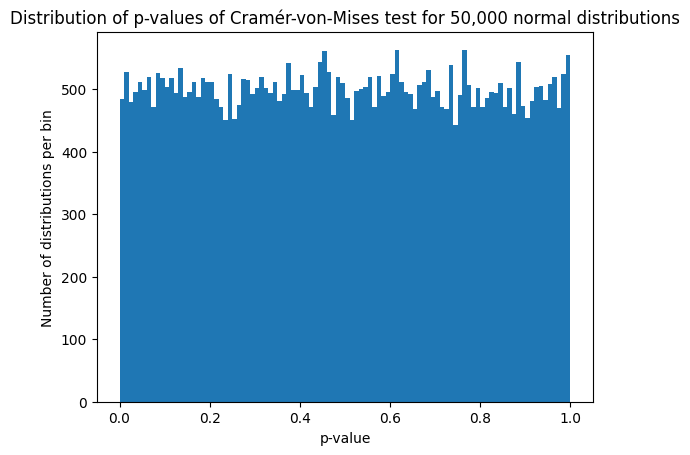

In [6]:
testdata_cvm = []
for i in range(50000):
    testdata_cvm.append(stats.cramervonmises_2samp(np.random.normal(size=100), np.random.normal(size=100)).pvalue)
plt.hist(testdata_cvm, bins=100)
plt.title("Distribution of p-values of Cramér-von-Mises test for 50,000 normal distributions")
plt.xlabel("p-value")
plt.ylabel("Number of distributions per bin")
plt.show()

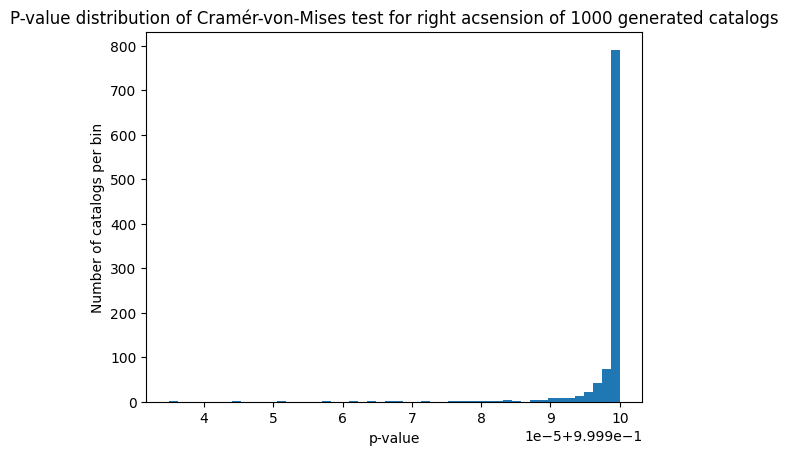

In [7]:
testdata_cvm_ra = []
for i in range(1000):
    testdata_cvm_ra.append(stats.cramervonmises_2samp(catalogs[i][0], np.array(df["RA"])).pvalue)
plt.hist(testdata_cvm_ra, bins=50)
plt.title("P-value distribution of Cramér-von-Mises test for right acsension of 1000 generated catalogs")
plt.xlabel("p-value")
plt.ylabel("Number of catalogs per bin")
plt.show()

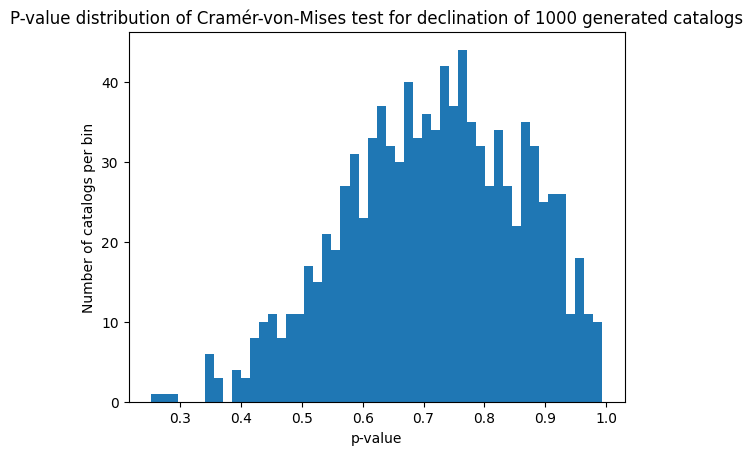

In [8]:
testdata_cvm_dec = []
for i in range(1000):
    testdata_cvm_dec.append(stats.cramervonmises_2samp(catalogs[i][1], np.array(df["DEC"])).pvalue)
plt.hist(testdata_cvm_dec, bins=50)
plt.title("P-value distribution of Cramér-von-Mises test for declination of 1000 generated catalogs")
plt.xlabel("p-value")
plt.ylabel("Number of catalogs per bin")
plt.show()

## For comparison, this was the old algorithm:

In [9]:
old={}
for i in range(1000): # Put the number of catalogs to be generated into this range()-function
    old[i] = (np.array([z+random.uniform(-10, 10) for z in df["RA"].tolist()]), np.array([z+random.uniform(-10, 10) for z in df["DEC"].tolist()]))
    for j in range(1177):
# Shift all blazars outside the outer boundaries back inside:
        if old[i][1][j] > -5:
            old[i][1][j] = old[i][1][j] - 5
        if old[i][1][j] < -85:
            old[i][1][j] = old[i][1][j] + 5
        if old[i][0][j] > 360:
            old[i][0][j] = old[i][0][j] - 10
        if old[i][0][j] < 0:
            old[i][0][j] = old[i][0][j] + 10
# Shift all blazars near the galactic plane into the boundaries:
    old_gal = SkyCoord(ra=old[i][0]*u.degree, dec=old[i][1]*u.degree, frame="icrs").galactic
    for j in range(1177):
        if 0 < old_gal.b.value[j] < 10:
            old[i][1][j] = SkyCoord(l = old_gal.l.value[j]*u.degree, b = (old_gal.b.value[j] + 10)*u.degree, frame="galactic").icrs.dec.value
            old[i][0][j] = SkyCoord(l = old_gal.l.value[j]*u.degree, b = (old_gal.b.value[j] + 10)*u.degree, frame="galactic").icrs.ra.value
        if -10 < old_gal.b.value[j] < 0:
            old[i][1][j] = SkyCoord(l = old_gal.l.value[j]*u.degree, b = (old_gal.b.value[j] - 10)*u.degree, frame="galactic").icrs.dec.value
            old[i][0][j] = SkyCoord(l = old_gal.l.value[j]*u.degree, b = (old_gal.b.value[j] - 10)*u.degree, frame="galactic").icrs.ra.value
# If the previous shifting of blazars near the galactic plane causes a blazar to be above the equatorial plane, this will shift it back down:            
        if old[i][1][j] > -5:
            old[i][1][j] = old[i][1][j] - 5

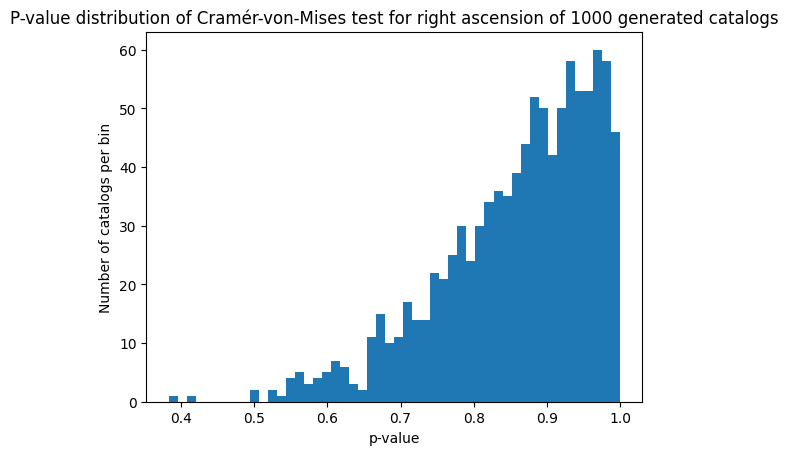

In [10]:
testdata_cvm_ra_old = []
for i in range(1000):
    testdata_cvm_ra_old.append(stats.cramervonmises_2samp(old[i][1], np.array(df["RA"])).pvalue)
plt.hist(testdata_cvm_ra_old, bins=50)
plt.title("P-value distribution of Cramér-von-Mises test for right ascension of 1000 generated catalogs")
plt.xlabel("p-value")
plt.ylabel("Number of catalogs per bin")
plt.show()

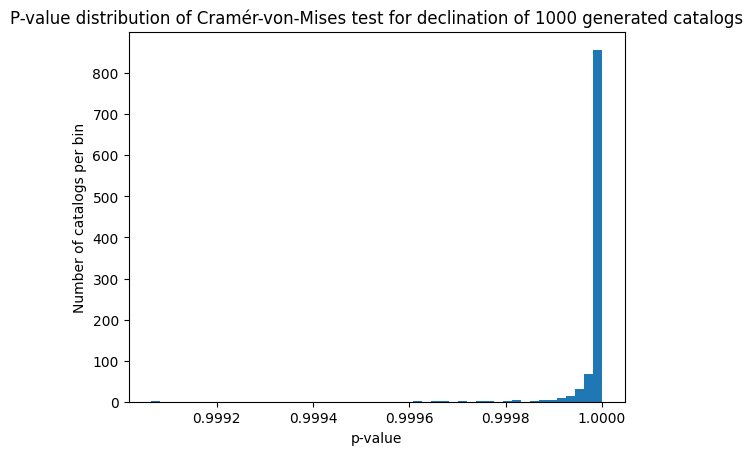

In [11]:
testdata_cvm_dec_old = []
for i in range(1000):
    testdata_cvm_dec_old.append(stats.cramervonmises_2samp(old[i][0], np.array(df["DEC"])).pvalue)
plt.hist(testdata_cvm_dec_old, bins=50)
plt.title("P-value distribution of Cramér-von-Mises test for declination of 1000 generated catalogs")
plt.xlabel("p-value")
plt.ylabel("Number of catalogs per bin")
plt.show()